In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import copy


x_col = ['text', 'datetime', 'retweet_count', 'favorite_count', 'place_full_name']
y_col = ['who']

# comma delimited is the default
#df = pd.read_csv(input_file, header = 0)
X_train = pd.read_csv('tweets/tweets-train-data.csv', names = x_col)
y_train = pd.read_csv('tweets/tweets-train-targets.csv', names = y_col)
X_train = X_train.drop('datetime', 1)
X_train = X_train.drop('place_full_name', 1)


X_test = pd.read_csv('tweets/tweets-test-data.csv', names = x_col)
y_test = pd.read_csv('tweets/tweets-test-targets.csv', names = y_col)
X_test = X_test.drop('datetime', 1)
X_test = X_test.drop('place_full_name', 1)

X_test.head()


# Let's check the length of the two sets
#len(X_train), len(X_test)

,text,retweet_count,favorite_count
0,we dont know why trump and putin praise each o...,7475,11964
1,is really starting to campaign hard for marcor...,1687,4672
2,find out where to on caucus night in iowa on 2116,1556,3504
3,100 true gt is right did call tpp the gold s...,7419,12728
4,i took trump university class and saved my home,2879,7931


In [2]:
#Change HC -> 0 and DT ->1 into the y dataframes.
dict = {'HC': 0, 'DT': 1}

y_train = y_train.replace({"who": dict})
y_train.head()

y_test = y_test.replace({"who": dict})
y_test.head()


,who
0,0
1,1
2,1
3,1
4,1


In [5]:
# Again, we have to add some code to have this run on the lab PCs
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import numpy as np

try:
    from sklearn.model_selection import KFold, cross_val_score
    legacy = False 
except ImportError:
    from sklearn.cross_validation import KFold, cross_val_score
    legacy = True
    
# 3-fold cross-validation
# random_state ensures same split for each value of gamma
# KFold has a different syntax for legacy versions of scikit-learn
if legacy:
    kf = KFold(len(y_train),n_folds=3, shuffle=True, random_state=42)
else:
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

gamma_values = [0.1, 0.05, 0.02, 0.01]
accuracy_scores = []

# Do model selection over all the possible values of gamma 
for gamma in gamma_values:
    
    # Train a classifier with current gamma
    #clf = SVC(C=10, kernel='rbf', gamma=gamma)
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(C=10, kernel='rbf', gamma=gamma)),])

    # Compute cross-validated accuracy scores
    # So legacy....
    if legacy: 
        scores = cross_val_score(text_clf, X_train.text, y_train.who, cv=kf, scoring='accuracy')
    else:
         scores = cross_val_score(text_clf, X_train.text, y_train.who, cv=kf.split(X_train), scoring='accuracy')
    
    # Compute the mean accuracy and keep track of it
    accuracy_score = scores.mean()
    accuracy_scores.append(accuracy_score)

# Get the gamma with highest mean accuracy
best_index = np.array(accuracy_scores).argmax()
best_gamma = gamma_values[best_index]

best_gamma

# Train over the full training set with the best gamma
clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(C=10, kernel='rbf', gamma=best_gamma)),])
clf.fit(X_train.text, y_train.who)

# Evaluate on the test set
y_pred = clf.predict(X_test.text)
accuracy = metrics.accuracy_score(y_test, y_pred)

accuracy

0.8932340161390441

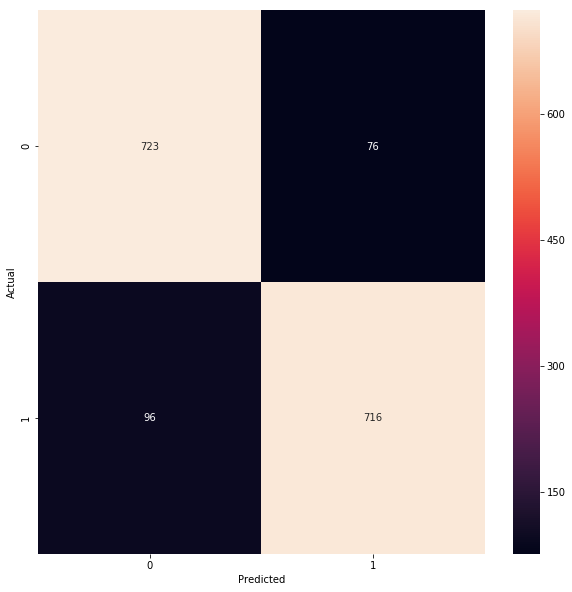

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       799
           1       0.90      0.88      0.89       812

   micro avg       0.89      0.89      0.89      1611
   macro avg       0.89      0.89      0.89      1611
weighted avg       0.89      0.89      0.89      1611



In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#Convert 0,1 int HC & DT

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[0,1], yticklabels=[0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

report = metrics.classification_report(y_test.values, y_pred)
print(report)

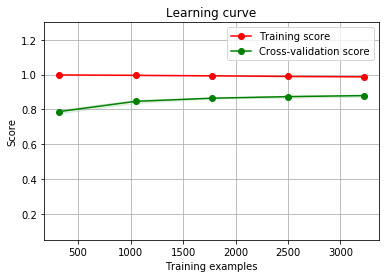

In [12]:
try:
    from sklearn.model_selection import learning_curve
except ImportError:
    from sklearn.learning_curve import learning_curve
    
    
plt.figure()
plt.title("Learning curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Compute the scores of the learning curve
# by default the (relative) dataset sizes are: 10%, 32.5%, 55%, 77.5%, 100% 
train_sizes, train_scores, test_scores = learning_curve(clf, X_train.text, y_train.who, scoring='accuracy', cv=3)

# Get the mean and std of train and test scores along the varying dataset sizes
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the mean and std for the training scores
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")

# Plot the mean and std for the cross-validation scores
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.ylim(0.05,1.3)             # set bottom and top limits for y axis
plt.legend()
plt.show()

In [17]:
#Export the predicted table
print (y_pred)
file_name = 'test-pred.txt'
            
with open('export/' + file_name, 'w') as f:
    for item in y_pred:
        f.write("%s\n" % item)

[0 1 1 ... 0 1 0]
